In [1]:
import numpy as np
import pywt
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
img = cv2.imread('./test_images/steve_1.jpg')
img.shape

(134, 178, 3)

In [7]:
k = img.reshape(-1,2)
k.shape

(35778, 2)

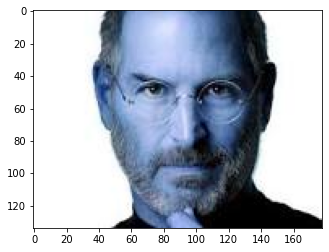

In [9]:
plt.imshow(img)

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(134, 178)

In [5]:
gray

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ...,   1,   4,   9],
       [255, 255, 255, ...,   0,   0,   3],
       [255, 255, 255, ...,   0,   1,   3]], dtype=uint8)

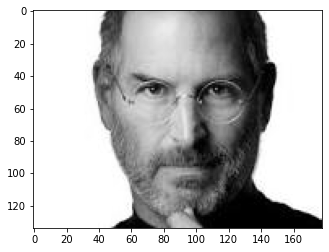

In [6]:
plt.imshow(gray, cmap='gray')

## First lets try detecting the face and eyes using haar cascades

### where we make use of the readymade API's of  xml files from open CV to detect different features on the face

In [7]:
face= cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face.detectMultiScale(gray, 1.3, 5)
faces #[x,y,width,height] we get two arrays if there are two images as we can observe in the above image

array([[ 43,  10, 104, 104]])

In [8]:
(x,y,w,h) = faces[0]
x,y,w,h

(43, 10, 104, 104)

#### Now let's draw a rectangle box denoting the face

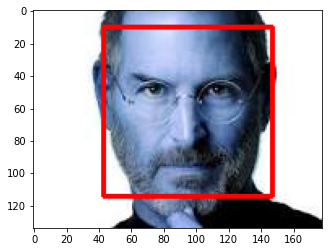

In [9]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

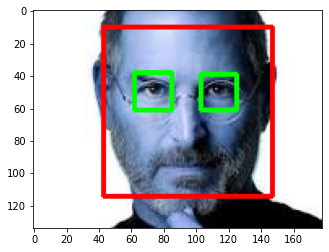

In [10]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

# roi is the region of interest

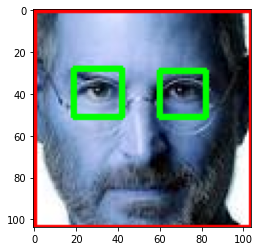

In [11]:
%matplotlib inline
plt.imshow(roi_color,cmap="gray")   #we get a cropped region of interest

In [12]:
def get_cropped_image_if_2_eyes(image_path):

    img = cv2.imread(image_path)

    if img is not None:

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        faces = face.detectMultiScale(gray, 1.3, 5)

        for (x,y,w,h) in faces:

            roi_gray = gray[y:y+h, x:x+w]

            roi_color = img[y:y+h, x:x+w]

            eyes = eye.detectMultiScale(roi_gray)

            if len(eyes) >= 2:
                
                return roi_color


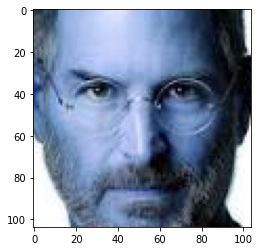

In [13]:
cropped_image = get_cropped_image_if_2_eyes('./test_images/steve_1.jpg')
plt.imshow(cropped_image)

### lets check for the obstructed image

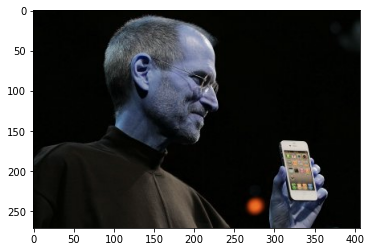

In [14]:
org_image_obstructed = cv2.imread('./test_images/steve_2.jpg')
plt.imshow(org_image_obstructed)

In [16]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('./test_images/steve_2.jpg')
cropped_image_no_2_eyes

#### Here we observe that function leaves out image if eyes and face are not clear

In [17]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [18]:
## store all individual subfolders in python list

import os

imgdr = []

for p in os.scandir(path_to_data):
    if p.is_dir():
        imgdr.append(p.path)
        

In [19]:
imgdr

['./dataset/Elon_musk', './dataset/Steve_Jobs', './dataset/virat_kohli']

In [20]:
### creating cropped folder inside dataset

import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [21]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in imgdr:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            
            cv2.imwrite(cropped_file_path, roi_color)
            
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1
           

            

Generating cropped images in folder:  ./dataset/cropped/Elon_musk
Generating cropped images in folder:  ./dataset/cropped/Steve_Jobs
Generating cropped images in folder:  ./dataset/cropped/virat_kohli


### Effectively extract features from the image using wavelet transform

In [22]:
def w2d(img, mode='haar', level=1):
    
    imArray = img
    
    #Datatype conversions
    #convert to grayscale
    
    imArray = cv2.cvtColor(imArray,cv2.COLOR_RGB2GRAY)
    #convert to float
    
    imArray =  np.float32(imArray)   
    imArray /= 255;
    
    # compute coefficients
    
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

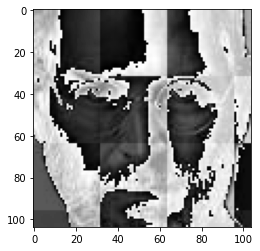

In [23]:
im_har = w2d(cropped_image,'db1',5)
plt.imshow(im_har,cmap = 'gray')

### we do this for all the cropped images, then we stack the original and the wavelet transformed image which we'll feed this as input to the classifier

In [25]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict



{'Elon_musk': ['./dataset/cropped/Elon_musk\\Elon_musk1.png',
  './dataset/cropped/Elon_musk\\Elon_musk10.png',
  './dataset/cropped/Elon_musk\\Elon_musk11.png',
  './dataset/cropped/Elon_musk\\Elon_musk12.png',
  './dataset/cropped/Elon_musk\\Elon_musk13.png',
  './dataset/cropped/Elon_musk\\Elon_musk14.png',
  './dataset/cropped/Elon_musk\\Elon_musk15.png',
  './dataset/cropped/Elon_musk\\Elon_musk16.png',
  './dataset/cropped/Elon_musk\\Elon_musk17.png',
  './dataset/cropped/Elon_musk\\Elon_musk18.png',
  './dataset/cropped/Elon_musk\\Elon_musk19.png',
  './dataset/cropped/Elon_musk\\Elon_musk2.png',
  './dataset/cropped/Elon_musk\\Elon_musk20.png',
  './dataset/cropped/Elon_musk\\Elon_musk21.png',
  './dataset/cropped/Elon_musk\\Elon_musk23.png',
  './dataset/cropped/Elon_musk\\Elon_musk24.png',
  './dataset/cropped/Elon_musk\\Elon_musk26.png',
  './dataset/cropped/Elon_musk\\Elon_musk27.png',
  './dataset/cropped/Elon_musk\\Elon_musk28.png',
  './dataset/cropped/Elon_musk\\Elon_mu

In [26]:
class_dict = {};
c = 0;

for name in celebrity_file_names_dict.keys():
    
    class_dict[name] = count
    count = count+1

class_dict

{'Elon_musk': 49, 'Steve_Jobs': 50, 'virat_kohli': 51}

In [27]:
class_dict['Elon_musk'] = 0
class_dict['Steve_Jobs'] = 1
class_dict['virat_kohli'] = 2

In [28]:
class_dict

{'Elon_musk': 0, 'Steve_Jobs': 1, 'virat_kohli': 2}

In [29]:
x = []
y = []


for tech_name,training_files in celebrity_file_names_dict.items():
    for t_image in training_files:
        
        img = cv2.imread(t_image) #color image
        
        if img is None:
            continue
        scaled_img = cv2.resize(img,(32,32)) #to maintain the same size as each differ
        img_har = w2d(img,'db1',5)
        scaled_img_har = cv2.resize(img_har,(32,32))
        
        #we can vertically stack using numpy
        
        stack_comb = np.vstack((scaled_img.reshape(32*32*3,1),scaled_img_har.reshape(32*32,1)))
        x.append(stack_comb)
        y.append(tech_name)
        
        

In [30]:
len(x)

89

In [31]:
x = np.array(x).reshape(len(x),4096).astype(float)
x.shape

(89, 4096)

In [32]:
x

array([[175., 188., 204., ..., 236.,  53.,  82.],
       [ 79., 102.,  98., ...,  60.,  57., 112.],
       [114., 132., 139., ...,  23., 179.,  22.],
       ...,
       [250., 173., 135., ...,   9.,   4., 252.],
       [ 17.,  35.,  54., ...,  32.,  62., 199.],
       [227., 114.,  27., ..., 245.,   1.,  51.]])

## Training model

#### we will use SVM with rbf kernel tuned with heuristic finetuning

In [33]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [35]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8260869565217391

In [36]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

   Elon_musk       1.00      0.75      0.86         8
  Steve_Jobs       1.00      0.71      0.83         7
 virat_kohli       0.67      1.00      0.80         8

    accuracy                           0.83        23
   macro avg       0.89      0.82      0.83        23
weighted avg       0.88      0.83      0.83        23



### Grid search CV hyperparameter tuning

In [37]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [38]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    
    
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [39]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.819780,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.715385,{'randomforestclassifier__n_estimators': 5}
2,logistic_regression,0.835165,{'logisticregression__C': 1}


In [40]:


best_estimators



{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=5))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [41]:
best_estimators['svm'].score(X_test,y_test)

0.8260869565217391

In [42]:
best_estimators['random_forest'].score(X_test,y_test)

0.6521739130434783

In [43]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8695652173913043

In [44]:
best_clf = best_estimators['logistic_regression']

In [45]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[7, 1, 0],
       [0, 5, 2],
       [0, 0, 8]], dtype=int64)

Text(69.0, 0.5, 'Truth')

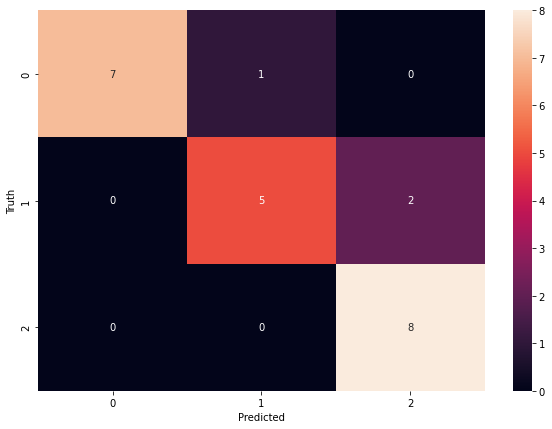

In [46]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

### Save the trained model

In [49]:
#!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

### Save class dict

In [50]:
import json
with open("Class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))